In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from dataset import *

from torchsummary import summary

np.random.seed(0)
torch.manual_seed(0)

In [2]:
train_set, val_set, test_set = generate_adni_datasets(datasplit=0.1)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
val_loader = DataLoader(val_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

[('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/train/AD/*', 1), ('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/train/NC/*', 0)]
[('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/test/AD/*', 1), ('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/test/NC/*', 0)]
[('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/train/AD/*', 1), ('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/recognition/45816967_ADNI_Vision_Transformer/data/ADNI_AD_NC_2D/AD_NC/train/NC/*', 0)]
[('C:/Users/Jun Khai/Documents/Uni/Year 5 Sem 2/PatternAnalysis-2023/

In [3]:
patch_size = 16
height = 192
width = 192

In [4]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=1,
                 patch_size:int=16,
                 embedding_dim:int=256):
        super().__init__()
        
        self.patch_size = patch_size
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1)

In [5]:
image = next(iter(train_loader))[0][0].type(torch.FloatTensor) # get a single image from the training set
print(image)
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=1,
                          patch_size=16,
                          embedding_dim=256)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Input image shape: torch.Size([1, 1, 192, 192])
Output patch embedding shape: torch.Size([1, 144, 256])


In [6]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.4160, -0.0301,  0.8705,  1.2712, -0.3000, -0.2126,  0.9443,
           1.2288,  3.3832,  1.6396]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 256]) -> [batch_size, number_of_tokens, embedding_dimension]
tensor([[[ 0.4160, -0.0301,  0.8705,  ..., -1.0675, -1.5815, -0.3388],
         [ 0.0199, -0.0270, -0.0365,  ..., -0.0389,  0.0208,  0.0521],
         [ 0.0199, -0.0270, -0.0365,  ..., -0.0389,  0.0208,  0.0521],
         ...,
         [ 0.0199, -0.0270, -0.0365,  ..., -0.0389,  0.0208,  0.0521],
         [ 0.0199, -0.0270, -0.0365,  ..., -0.0389,  0.0208,  0.0521],
         [ 0.0199, -0.0270, -0.0365,  ..., -0.0389,  0.0208,  0.0521]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 145, 256]) -> [batch_size, number_of_patches, embedding_dimension]


In [7]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.3684,  0.1862,  2.2920,  0.8667,  0.1289, -0.6571, -0.0138,
          -0.4829,  0.3643,  1.7488],
         [ 0.2331, -0.6707, -2.4444,  1.0839, -0.7864,  0.4866, -0.6176,
           0.9187,  1.0115,  1.2355],
         [ 0.6752,  0.4555,  0.0477, -1.2221,  0.0928,  1.5178,  0.7460,
          -1.0673, -0.9299, -1.1938],
         [-1.6866, -0.0554, -1.6815,  0.3528,  0.1378, -0.0955,  0.1658,
          -1.2463, -0.8413, -0.4132],
         [ 0.0133, -0.1274, -1.0988,  2.8562, -0.6011,  0.0146,  0.0223,
          -0.1417, -0.2531, -1.0929],
         [-1.0381,  1.0419,  0.2228,  0.9821,  0.5108, -0.2946, -0.4995,
          -0.3501, -0.1617, -0.1941],
         [-0.1624,  0.2829,  0.6180, -1.4563,  0.6712, -0.3176,  0.0991,
           0.5153,  2.2310, -1.0062],
         [ 0.6157,  0.6848, -0.1352,  0.2974,  0.0926, -0.2204,  0.8335,
           0.2264, -0.2843, -0.0041],
         [-0.9907,  0.9778,  1.4184,  0.4493, -0.4542,  0.8511,  1.3485,
           0.4842, -1.8409,  0.6771],
 

In [8]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.7844,  0.1561,  3.1625,  ..., -0.9578,  0.0072, -1.9360],
         [ 0.2530, -0.6976, -2.4809,  ..., -0.2415, -0.0251, -0.7506],
         [ 0.6951,  0.4285,  0.0113,  ...,  1.3268,  0.3890, -0.5660],
         ...,
         [-0.0136, -1.2977,  0.2951,  ...,  1.3301, -0.8785, -0.7795],
         [ 0.9251, -2.0238, -1.2257,  ..., -0.4721,  1.6415, -1.9548],
         [-0.9937, -0.0647,  0.6774,  ...,  0.8801,  1.6800, -0.8195]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 145, 256]) -> [batch_size, number_of_patches, embedding_dimension]


In [9]:
# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding()

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([1, 192, 192])
Input image with batch dimension shape: torch.Size([1, 1, 192, 192])
Patching embedding shape: torch.Size([1, 144, 256])
Class token embedding shape: torch.Size([1, 1, 256])
Patch embedding with class token shape: torch.Size([1, 145, 256])
Patch and position embedding shape: torch.Size([1, 145, 256])


In [10]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=256, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [11]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=256, # from Table 1 
                                                             num_heads=8) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 145, 256])
Output shape MSA block: torch.Size([1, 145, 256])


In [12]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=256, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [13]:
# Create an instance of MLPBlock
mlp_block = MLPBlock()

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 145, 256])
Output shape MLP block: torch.Size([1, 145, 256])


In [14]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=256, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=8, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [15]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=192, # Training resolution from Table 3 in ViT paper
                 in_channels:int=1, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=8, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=128, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=128, # MLP size from Table 1 for ViT-Base
                 num_heads:int=8, # Heads from Table 1 for ViT-Base
                 dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=2): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        self.transformer_encoder = nn.Sequential(*[nn.TransformerEncoderLayer(d_model=embedding_dim, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=num_heads, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=mlp_size, # MLP size from Table 1 for ViT-Base
                                                             dropout=dropout, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) for _ in range(num_transformer_layers)])
       
        
        # # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # # Note: The "*" means "all"
        # self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
        #                                                                     num_heads=num_heads,
        #                                                                     mlp_size=mlp_size,
        #                                                                     mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes),
            nn.Softmax(dim=-1) # calculate softmax across the last dimension
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [16]:
from torchinfo import summary

model = ViT().to(device)
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(128, 1, 192, 192), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                [128, 1, 192, 192]   [128, 2]             18,688               True
├─PatchEmbedding (patch_embedding)       [128, 1, 192, 192]   [128, 144, 128]      --                   True
│    └─Conv2d (patcher)                  [128, 1, 192, 192]   [128, 128, 12, 12]   32,896               True
│    └─Flatten (flatten)                 [128, 128, 12, 12]   [128, 128, 144]      --                   --
├─Dropout (embedding_dropout)            [128, 145, 128]      [128, 145, 128]      --                   --
├─Sequential (transformer_encoder)       [128, 145, 128]      [128, 145, 128]      --                   True
│    └─TransformerEncoderLayer (0)       [128, 145, 128]      [128, 145, 128]      99,584               True
│    └─TransformerEncoderLayer (1)       [128, 145, 128]      [128, 145, 128]      99,584               True
│    └─Transformer

In [17]:
version_prefix = "vit9"

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model = ViT(num_transformer_layers=12, embedding_dim=256, mlp_size=256, num_heads=16).to(device)
# model = ViT(image_size=192, patch_size=4, num_classes=2, depth=4, heads=4, mlp_dim=4, dropout=0.1).to(device)

N_EPOCHS = 50
LR = 0.0005
train_losses = []
val_losses = []
val_accs = []
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in range(N_EPOCHS): #trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.type(torch.FloatTensor).to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")
    torch.save(model, f"models/{version_prefix}_model_{epoch + 1}_{train_loss}.pth")
    
    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validation"):
            x, y = batch
            x, y = x.type(torch.FloatTensor).to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            val_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        val_acc = correct / total * 100
        val_accs.append(val_acc)
        print(f"Val loss: {val_loss:.2f}")
        print(f"Val accuracy: {correct / total * 100:.2f}%")
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)



Using device:  cuda (NVIDIA GeForce RTX 3060 Ti)


Epoch 1/50 loss: 0.71


Validation: 100%|██████████| 17/17 [00:02<00:00,  7.61it/s]


Val loss: 0.16
Val accuracy: 57.52%


Epoch 2/50 loss: 0.64


Validation: 100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


Val loss: 0.16
Val accuracy: 61.26%


Epoch 3/50 loss: 0.60


Validation: 100%|██████████| 17/17 [00:02<00:00,  8.06it/s]


Val loss: 0.15
Val accuracy: 64.21%


Epoch 4/50 loss: 0.57


Validation: 100%|██████████| 17/17 [00:02<00:00,  8.05it/s]


Val loss: 0.15
Val accuracy: 65.51%


Epoch 5/50 loss: 0.56


Validation: 100%|██████████| 17/17 [00:02<00:00,  7.65it/s]


Val loss: 0.15
Val accuracy: 66.31%


Epoch 6/50 loss: 0.53


Validation: 100%|██████████| 17/17 [00:02<00:00,  7.62it/s]


Val loss: 0.16
Val accuracy: 61.68%


Epoch 7 in training:   1%|▏         | 2/152 [00:02<02:47,  1.11s/it]

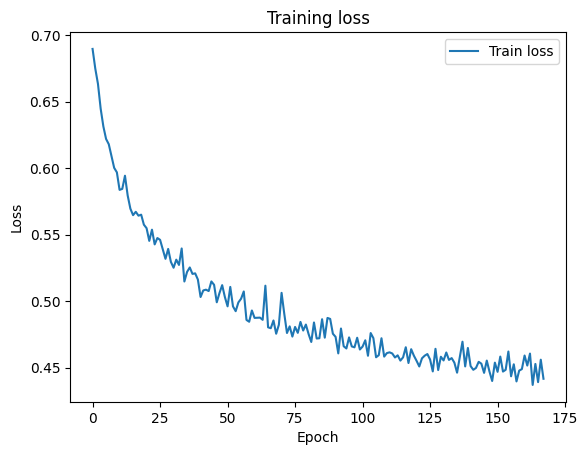

<function matplotlib.pyplot.show(close=None, block=None)>

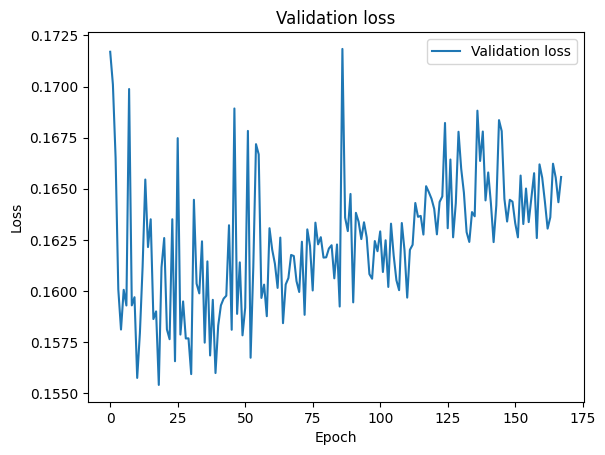

In [ ]:
plt.plot(train_losses, label="Train loss")
# label the plot
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# save figure
plt.savefig(f"{version_prefix}_trainloss.png")
plt.show()


plt.plot(val_losses, label="Validation loss")
# label the plot
plt.title("Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# save figure
plt.savefig(f"{version_prefix}_valloss.png")
plt.show

In [ ]:
model2 = torch.load("models/vit2_model_12_0.5835193874020326.pth")

In [ ]:
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing: 100%|██████████| 71/71 [04:20<00:00,  3.67s/it]

Test loss: 0.77
Test accuracy: 49.56%
